In [1]:
#important libraries
import os
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import albumentations as A
import cv2
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter 
import ntpath 
from PIL import Image
import shutil
from Pytorch_Modules import model_runtime
from timeit import default_timer as timer

/home/jagannath/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-01 17:28:41.052009: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-01 17:28:41.052846: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-01 17:28:41.057077: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-01 17:28:41.069121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register facto

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#visualising the  structure of the data
data='Training_data'
columns=['center','left','right','steering','throttle','reverse','speed']
dataset=pd.read_csv('updated_driving_log.csv',names=columns)
pd.set_option('display.max_colwidth',1)

#cutting the image name to just the jpg filename for clarity
def path_leaf(path):
    head, tail=ntpath.split(path)
    return tail

dataset['center']=dataset['center'].apply(path_leaf)
dataset['left']=dataset['left'].apply(path_leaf)
dataset['right']=dataset['right'].apply(path_leaf)
dataset.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2024_12_31_07_47_57_507.jpg,left_2024_12_31_07_47_57_507.jpg,right_2024_12_31_07_47_57_507.jpg,0.0,0.0,0.0,0.000079
1,center_2024_12_31_07_47_57_622.jpg,left_2024_12_31_07_47_57_622.jpg,right_2024_12_31_07_47_57_622.jpg,0.0,0.0,0.0,0.000078
2,center_2024_12_31_07_47_57_731.jpg,left_2024_12_31_07_47_57_731.jpg,right_2024_12_31_07_47_57_731.jpg,0.0,0.0,0.0,0.000079
3,center_2024_12_31_07_47_57_844.jpg,left_2024_12_31_07_47_57_844.jpg,right_2024_12_31_07_47_57_844.jpg,0.0,0.0,0.0,0.000079
4,center_2024_12_31_07_47_57_966.jpg,left_2024_12_31_07_47_57_966.jpg,right_2024_12_31_07_47_57_966.jpg,0.0,0.0,0.0,0.000079


In [4]:
len(dataset), dataset.shape #7 is the number of columns

(4608, (4608, 7))

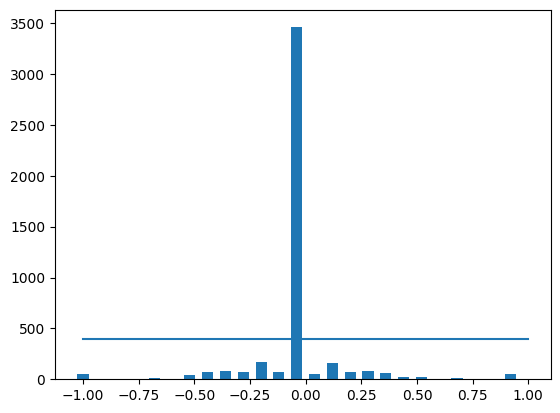

In [5]:
#probablity distribution of steering angle
num_bins=25
sample_per_bins=400
hist, bins=np.histogram(dataset['steering'],num_bins)
center=(bins[:-1]+bins[:-1])*0.5
plt.bar(center,hist, width=0.05)
plt.plot((np.min(dataset['steering']),np.max(dataset['steering'])),(sample_per_bins,sample_per_bins))

Filtered dataset length: 1549


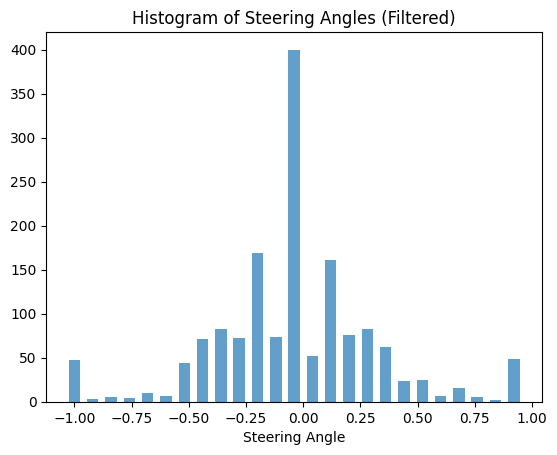

In [6]:
#from the above data, as zeroes occur more, we need to remove some of the zeroes (all zeroes above that line)
steering_angles = np.array(dataset['steering'])

# Filter data to limit samples per bin
remove_indices = []
for i in range(num_bins):
    bin_indices = np.where((steering_angles >= bins[i]) & (steering_angles < bins[i + 1]))[0]
    if len(bin_indices) > sample_per_bins:
        remove_indices.extend(bin_indices[sample_per_bins:])

# Filter the data (steering angles and image paths)
steering_angles_filtered = np.delete(steering_angles, remove_indices)
dataset_filtered = dataset.drop(remove_indices)

# After filtering, we have the remaining dataset that you can use
print("Filtered dataset length:", len(dataset_filtered))

# Plot filtered histogram
hist_filtered, _ = np.histogram(steering_angles_filtered, num_bins)
plt.bar(center, hist_filtered, width=0.05, alpha=0.7)
plt.xlabel("Steering Angle")
plt.title("Histogram of Steering Angles (Filtered)")
plt.show()

In [7]:
len(dataset_filtered), len(steering_angles_filtered),len(dataset)

(1549, 1549, 4608)

In [8]:
#function for splitting the data into training and testing folders(each with left, center, right camera images)
# and a steering.csv file (try with unfiltered/filtered dataset)
def split_data(dataset, train_dir, test_dir, test_size=0.2):
    # Create directories for train and test data
    os.makedirs(os.path.join(train_dir, 'center'), exist_ok=True)

    os.makedirs(os.path.join(test_dir, 'center'), exist_ok=True)

    # Get indices for splitting
    num_samples = len(dataset)
    num_test_samples = int(num_samples * test_size)
    train_indices = np.random.choice(num_samples, num_samples - num_test_samples, replace=False)
    test_indices = np.setdiff1d(np.arange(num_samples), train_indices)

    # Function to copy image files only if not already in destination
    def copy_if_needed(src, dst):
        if not os.path.exists(dst):
            shutil.copy(src, dst)

    # Copy image files to train directory
    for idx in train_indices:
        for side in ['center']:
            image_file = dataset.iloc[idx][side]
            src = image_file  # Use the full path directly from the dataset
            dst = os.path.join(train_dir, side, os.path.basename(image_file))
            copy_if_needed(src, dst)
    
    # Copy image files to test directory
    for idx in test_indices:
        for side in ['center']:
            image_file = dataset.iloc[idx][side]
            src = image_file  # Use the full path directly from the dataset
            dst = os.path.join(test_dir, side, os.path.basename(image_file))
            copy_if_needed(src, dst)

    # Save corresponding steering angles with image paths for both train and test splits
    train_data = dataset.iloc[train_indices][['center', 'steering']]
    test_data = dataset.iloc[test_indices][['center', 'steering']]
    
    # Save the data (image paths + steering angles) to CSV files
    train_data.to_csv(os.path.join(train_dir, 'steering_angles.csv'), index=False)
    test_data.to_csv(os.path.join(test_dir, 'steering_angles.csv'), index=False)

    print(f"Length of Training data: {len(train_indices)} samples")
    print(f"Length of Testing data: {len(test_indices)} samples")

# Example usage
dataset = pd.read_csv('/home/jagannath/Desktop/SELF_DRIVING_DATA/Training_data/updated_driving_log.csv', 
                      names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'],header=None)
train_dir = 'train'
test_dir = 'test'

# Split the dataset into training and testing sets
split_data(dataset, train_dir, test_dir, test_size=0.2)

Length of Training data: 3687 samples
Length of Testing data: 921 samples


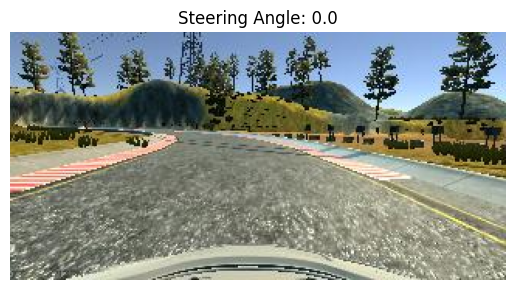


Image class (steering angle): 0.0
Image height: 160
Image width: 320
Image shape: (160, 320, 3)



In [9]:
# Select a random image from the dataset
random_row = dataset.sample(n=1).iloc[0]  # Randomly sample a single row
random_image_filename = random_row['center']  # Center image filename
image_label = random_row['steering']  # Steering angle as label

# Load the image
image_path = os.path.join('IMG', random_image_filename)  # Assuming images are in 'IMG' folder
image = Image.open(image_path)  # Load the image
image_as_an_array = np.asarray(image)

# Plot the image with the label
def plot_image(image, label):
    plt.imshow(image)
    plt.title(f"Steering Angle: {label}")
    plt.axis(False)
    plt.show()

# Display the image
plot_image(image, image_label)

# Print details about the image
print(f"\nImage class (steering angle): {image_label}")
print(f"Image height: {image.height}")
print(f"Image width: {image.width}")
print(f"Image shape: {image_as_an_array.shape}\n")

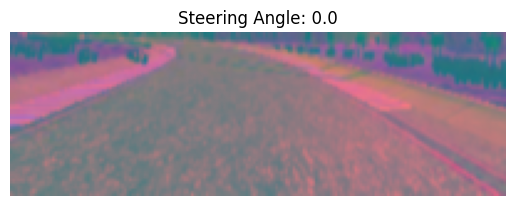

In [10]:
#creating training and testing dataset to put into the dataloader
class DrivingDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with steering angles and image filenames.
            img_dir (string): Directory with the images (center folder).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Load the CSV file with steering angles and image filenames
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        # Number of samples is the number of rows in the CSV file
        return len(self.data_frame)

    def __getitem__(self, idx):
        """Fetch a single sample from the dataset.
        Args: idx (int): Index of the sample to fetch."""

        # Get the row at index idx
        row = self.data_frame.iloc[idx]

        # Load the image for the center camera using the filenames from the CSV
        center_image_path = os.path.join(self.img_dir, 'center', row['center'])
        center_image = Image.open(center_image_path)

        # Get the steering angle (label)
        steering_angle = row['steering']

        # Convert image to NumPy array (required for albumentations)
        center_image = np.array(center_image)

        # Apply the transformations if any
        if self.transform:
            center_image = self.transform(center_image)

        # Preprocess the image (crop, resize, etc.)
        center_image = self.img_preprocess(center_image)

        # Convert image to PyTorch tensor and ensure (C, H, W) format
        center_image = np.transpose(center_image, (2, 0, 1))  # (H, W, C) to (C, H, W)
        center_image = torch.tensor(center_image, dtype=torch.float32)  # Convert to torch tensor

        # Convert steering angle to PyTorch tensor
        steering_angle = torch.tensor(steering_angle, dtype=torch.float32)

        # Return the transformed image and steering angle
        return {'center': center_image, 'steering': steering_angle}

    def img_preprocess(self, img):
        """Function to preprocess the image (crop, resize, convert to YUV, etc.)
        Args:
            img (np.array): Input image."""
        img = img[60:135, :, :]  # Crop the image
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)  # Convert to YUV color space
        img = cv2.GaussianBlur(img, (3, 3), 0)  # Apply Gaussian Blur
        img = cv2.resize(img, (200, 66))  # Resize image to (200, 66)
        img = img / 255.0  # Normalize the image to range [0, 1]
        return img

# Custom augmentations
def zoom(image):
    transform = A.RandomScale(scale_limit=(1, 1.3), p=1)
    return transform(image=image)["image"]

def pan(image):
    transform = A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=1)
    return transform(image=image)["image"]

def img_random_brightness(image):
    transform = A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1)
    return transform(image=image)["image"]

def img_random_flip(image):
    transform = A.HorizontalFlip(p=1)
    return transform(image=image)["image"]

def random_augment(image):
    image = np.array(image)  # Convert PIL image to NumPy array
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image = img_random_flip(image)
    return image

# Preprocessing the image
def img_preprocess(img):
    img = img[60:135, :, :]  # Crop the image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)  # Convert to YUV color space
    img = cv2.GaussianBlur(img, (3, 3), 0)  # Apply Gaussian Blur
    img = cv2.resize(img, (200, 66))  # Resize image to (200, 66)
    img = img / 255  # Normalize the image to range [0, 1]
    return img

# Define the paths for train and test CSV files and image directories
train_csv_file = os.path.join('/home/jagannath/Desktop/SELF_DRIVING_DATA/Training_data', 'train', 'steering_angles.csv')
test_csv_file = os.path.join('/home/jagannath/Desktop/SELF_DRIVING_DATA/Training_data', 'test', 'steering_angles.csv')

train_img_dir = os.path.join('/home/jagannath/Desktop/SELF_DRIVING_DATA/Training_data', 'train')
test_img_dir = os.path.join('/home/jagannath/Desktop/SELF_DRIVING_DATA/Training_data', 'test')


augmented_image = random_augment(image)
transformed_image = img_preprocess(augmented_image)

# Plot the transformed image
def plot_image(image, label):
    plt.imshow(image)
    plt.title(f"Steering Angle: {label}")
    plt.axis('off')
    plt.show()

plot_image(transformed_image, image_label)

In [11]:
class NvidiaModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)  # Input channels = 3 (YUV), output channels = 24
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3)  # Changed kernel size to 3x3
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3)  # Added 5th convolutional layer

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 1 * 18, 1164)  # Flattened dimension (calculated manually)
        self.fc2 = nn.Linear(1164, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 10)
        self.fc5 = nn.Linear(10, 1)  # Output layer
        
    def forward(self, x):
        # Convolutional layers with ELU activation
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = F.elu(self.conv5(x))

        # Flatten the output
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = self.fc5(x)
        return x

# Instantiate the model
model = NvidiaModel().to(device)

In [12]:
model

NvidiaModel(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=1164, bias=True)
  (fc2): Linear(in_features=1164, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
)

In [13]:
# Create the train and test datasets
train_dataset = DrivingDataset(csv_file=train_csv_file, img_dir=train_img_dir, transform=random_augment)
test_dataset = DrivingDataset(csv_file=test_csv_file, img_dir=test_img_dir, transform=random_augment)

In [14]:
len(train_dataset), len(test_dataset)

(3687, 921)

In [15]:
#preparing the dataloader
train_loader=DataLoader(dataset=train_dataset, batch_size=32, num_workers=os.cpu_count(), shuffle=True,pin_memory=True)
test_loader=DataLoader(dataset=test_dataset, batch_size=32, num_workers=os.cpu_count(), shuffle=True,pin_memory=True)


In [16]:
# Untrained prediction with 3 images (center, left, right)
torch.manual_seed(41)
for sample in train_loader:
    # Concatenate the three images (center, left, right) along the channel dimension
    images = sample['center']  # (C, H, W) - Center image
    
    # Steering angle
    labels = sample['steering']
    labels=labels.unsqueeze(1)

    # Move data to device
    images, labels = images.to(device), labels.to(device)

    # Make predictions using the model
    prediction = model(images)
    break  
prediction


tensor([[0.0190],
        [0.0190],
        [0.0194],
        [0.0193],
        [0.0192],
        [0.0195],
        [0.0194],
        [0.0192],
        [0.0200],
        [0.0191],
        [0.0195],
        [0.0190],
        [0.0192],
        [0.0194],
        [0.0189],
        [0.0188],
        [0.0192],
        [0.0189],
        [0.0187],
        [0.0188],
        [0.0196],
        [0.0197],
        [0.0193],
        [0.0194],
        [0.0193],
        [0.0190],
        [0.0194],
        [0.0191],
        [0.0200],
        [0.0190],
        [0.0192],
        [0.0196]], grad_fn=<AddmmBackward0>)

In [17]:
images.shape,labels.shape

(torch.Size([32, 3, 66, 200]), torch.Size([32, 1]))

In [18]:
def accuracy(output, labels):
    '''Mean Absolute Error (MAE) function for regression'''
    return torch.mean(torch.abs(output - labels)).item()

In [19]:
# Define loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [20]:
#loss batch function function
def loss_batch(model, loss_function, images, labels, opt, metrics=accuracy):
    prediction = model(images)
    loss = loss_function(prediction, labels)

    if opt is not None:

        loss.backward()
        opt.step()
        opt.zero_grad()

    metric_result = metrics(prediction, labels) if metrics else None
    return loss.item(), len(images), metric_result

In [21]:
def evaluate(model, loss_function, test_loader, metrics=accuracy):
    with torch.inference_mode():
        result = [loss_batch(model, loss_function, images.to(device), labels.to(device), opt=None, metrics=metrics)
                  for sample in test_loader]
        
        losses, num, metric = zip(*result)
        total = np.sum(num)
        loss = np.sum(np.multiply(losses, num)) / total

        metric_result = np.sum(np.multiply(metric, num)) / total if metrics else None
        return loss, total, metric_result

In [22]:
#training loop
def train_plot_tensorboard_multiple_experiments(experiment_configs, train_loaders, test_loaders, loss_function, metrics=accuracy):

    for exp_idx, config in enumerate(experiment_configs):
        model = config['model']
        optimizer = config['optimizer']
        exp_name = config['name']
        nepochs = config['epochs']

        train_loader = train_loaders[exp_idx]
        test_loader = test_loaders[exp_idx]

        writer = SummaryWriter(f'mega')

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        print(f"Experiment: {exp_name}")

        for epoch in tqdm(range(nepochs)):
            model.train()
            total_train_loss = 0.0
            total_train_metric = 0.0
            num_train_batches = 0

            for sample in train_loader:
                images = sample['center']
                labels = sample['steering']

                labels = labels.float()
                labels = labels.unsqueeze(1)

                images, labels = images.to(device), labels.to(device)

                train_loss, _, train_metric = loss_batch(model, loss_function, images, labels, optimizer, metrics=metrics)

                total_train_loss += train_loss
                total_train_metric += train_metric
                num_train_batches += 1

            avg_train_loss = total_train_loss / num_train_batches
            avg_train_metric = total_train_metric / num_train_batches

            # Append to lists
            train_losses.append(avg_train_loss)
            train_accuracies.append(avg_train_metric)

            model.eval()
            total_test_loss = 0.0
            total_test_metric = 0.0
            num_test_batches = 0

            for sample in test_loader:
                images = sample['center']
                labels = sample['steering']

                labels = labels.float()
                labels = labels.unsqueeze(1)

                images, labels = images.to(device), labels.to(device)

                test_loss, _, test_metric = evaluate(model, loss_function, test_loader, metrics=metrics)

                total_test_loss += test_loss
                total_test_metric += test_metric
                num_test_batches += 1

            avg_test_loss = total_test_loss / num_test_batches
            avg_test_metric = total_test_metric / num_test_batches

            # Append to lists
            test_losses.append(avg_test_loss)
            test_accuracies.append(avg_test_metric)

            # Log metrics
            writer.add_scalar('Loss/Train', avg_train_loss, epoch + 1)
            writer.add_scalar('Loss/Test', avg_test_loss, epoch + 1)
            writer.add_scalar('Metric/Train', avg_train_metric, epoch + 1)
            writer.add_scalar('Metric/Test', avg_test_metric, epoch + 1)

            print(f"Epoch {epoch + 1}/{nepochs}")
            print(f"Training loss: {avg_train_loss:.4f}, Test loss: {avg_test_loss:.4f}")
            print(f"Training MAE: {avg_train_metric:.4f}, Test MAE: {avg_test_metric:.4f}")
            print("---------------------------------------------------------\n")

        print(f"Average Training loss for {exp_name}: {sum(train_losses)/len(train_losses):.4f}")
        print(f"Average Test loss for {exp_name}: {sum(test_losses)/len(test_losses):.4f}")
        print(f"Average Training MAE for {exp_name}: {sum(train_accuracies)/len(train_accuracies):.4f}")
        print(f"Average Test MAE for {exp_name}: {sum(test_accuracies)/len(test_accuracies):.4f}")

        writer.close()

In [23]:
#training loop
#16. Training the Model
start_time = timer()

experiment_configs = [
    {
        'model': model,  
        'optimizer': optimizer,
        'epochs': 50, 
        'name': 'Training NVIDIA model for autonomous control'
    }
]

# Define the DataLoader for each model (train and test)
train_loaders = [train_loader]
test_loaders = [test_loader]

# Call the training function
train_plot_tensorboard_multiple_experiments(experiment_configs, train_loaders, test_loaders, loss_function)

end_time = timer()
model_runtime.run_time(start_time, end_time, device=device)

Experiment: Training NVIDIA model for autonomous control


  2%|▏         | 1/50 [01:26<1:10:37, 86.48s/it]

Epoch 1/50
Training loss: 0.0471, Test loss: 0.0729
Training MAE: 0.0995, Test MAE: 0.1334
---------------------------------------------------------



  4%|▍         | 2/50 [02:50<1:08:13, 85.29s/it]

Epoch 2/50
Training loss: 0.0462, Test loss: 0.0746
Training MAE: 0.0940, Test MAE: 0.1227
---------------------------------------------------------



  6%|▌         | 3/50 [04:16<1:06:53, 85.39s/it]

Epoch 3/50
Training loss: 0.0464, Test loss: 0.0725
Training MAE: 0.0963, Test MAE: 0.1340
---------------------------------------------------------



  8%|▊         | 4/50 [05:24<1:00:10, 78.49s/it]

Epoch 4/50
Training loss: 0.0653, Test loss: 0.0754
Training MAE: 0.1525, Test MAE: 0.1231
---------------------------------------------------------



 10%|█         | 5/50 [06:28<55:00, 73.36s/it]  

Epoch 5/50
Training loss: 0.0469, Test loss: 0.0760
Training MAE: 0.1043, Test MAE: 0.1267
---------------------------------------------------------



 12%|█▏        | 6/50 [07:32<51:28, 70.20s/it]

Epoch 6/50
Training loss: 0.0466, Test loss: 0.0784
Training MAE: 0.1001, Test MAE: 0.1381
---------------------------------------------------------



 14%|█▍        | 7/50 [08:36<48:52, 68.19s/it]

Epoch 7/50
Training loss: 0.0466, Test loss: 0.0794
Training MAE: 0.0996, Test MAE: 0.1425
---------------------------------------------------------



 16%|█▌        | 8/50 [09:40<46:47, 66.84s/it]

Epoch 8/50
Training loss: 0.0468, Test loss: 0.0727
Training MAE: 0.0980, Test MAE: 0.1328
---------------------------------------------------------



 18%|█▊        | 9/50 [10:45<45:12, 66.16s/it]

Epoch 9/50
Training loss: 0.0466, Test loss: 0.0767
Training MAE: 0.0967, Test MAE: 0.1304
---------------------------------------------------------



 20%|██        | 10/50 [11:49<43:37, 65.44s/it]

Epoch 10/50
Training loss: 0.0462, Test loss: 0.0745
Training MAE: 0.0955, Test MAE: 0.1216
---------------------------------------------------------



 22%|██▏       | 11/50 [12:53<42:13, 64.96s/it]

Epoch 11/50
Training loss: 0.0469, Test loss: 0.0726
Training MAE: 0.0954, Test MAE: 0.1342
---------------------------------------------------------



 24%|██▍       | 12/50 [13:57<40:57, 64.67s/it]

Epoch 12/50
Training loss: 0.0471, Test loss: 0.0750
Training MAE: 0.0962, Test MAE: 0.1214
---------------------------------------------------------



 26%|██▌       | 13/50 [15:01<39:47, 64.52s/it]

Epoch 13/50
Training loss: 0.0463, Test loss: 0.0751
Training MAE: 0.0940, Test MAE: 0.1214
---------------------------------------------------------



 28%|██▊       | 14/50 [16:05<38:43, 64.54s/it]

Epoch 14/50
Training loss: 0.0467, Test loss: 0.0735
Training MAE: 0.0919, Test MAE: 0.1271
---------------------------------------------------------



 30%|███       | 15/50 [17:09<37:31, 64.33s/it]

Epoch 15/50
Training loss: 0.0474, Test loss: 0.0771
Training MAE: 0.0946, Test MAE: 0.1317
---------------------------------------------------------



 32%|███▏      | 16/50 [18:13<36:24, 64.26s/it]

Epoch 16/50
Training loss: 0.0462, Test loss: 0.0777
Training MAE: 0.0946, Test MAE: 0.1353
---------------------------------------------------------



 34%|███▍      | 17/50 [19:17<35:15, 64.10s/it]

Epoch 17/50
Training loss: 0.0465, Test loss: 0.0761
Training MAE: 0.0958, Test MAE: 0.1295
---------------------------------------------------------



 36%|███▌      | 18/50 [20:21<34:08, 64.02s/it]

Epoch 18/50
Training loss: 0.0466, Test loss: 0.0760
Training MAE: 0.0936, Test MAE: 0.1275
---------------------------------------------------------



 38%|███▊      | 19/50 [21:24<33:00, 63.87s/it]

Epoch 19/50
Training loss: 0.0462, Test loss: 0.0761
Training MAE: 0.0925, Test MAE: 0.1268
---------------------------------------------------------



 40%|████      | 20/50 [22:28<31:55, 63.86s/it]

Epoch 20/50
Training loss: 0.0464, Test loss: 0.0744
Training MAE: 0.0931, Test MAE: 0.1235
---------------------------------------------------------



 42%|████▏     | 21/50 [23:32<30:51, 63.83s/it]

Epoch 21/50
Training loss: 0.0462, Test loss: 0.0742
Training MAE: 0.0912, Test MAE: 0.1228
---------------------------------------------------------



 44%|████▍     | 22/50 [24:38<30:02, 64.36s/it]

Epoch 22/50
Training loss: 0.0468, Test loss: 0.0742
Training MAE: 0.0949, Test MAE: 0.1220
---------------------------------------------------------



 46%|████▌     | 23/50 [25:41<28:51, 64.12s/it]

Epoch 23/50
Training loss: 0.0464, Test loss: 0.0743
Training MAE: 0.0938, Test MAE: 0.1215
---------------------------------------------------------



 48%|████▊     | 24/50 [26:44<27:40, 63.88s/it]

Epoch 24/50
Training loss: 0.0467, Test loss: 0.0731
Training MAE: 0.0956, Test MAE: 0.1288
---------------------------------------------------------



 50%|█████     | 25/50 [27:48<26:34, 63.79s/it]

Epoch 25/50
Training loss: 0.0461, Test loss: 0.0727
Training MAE: 0.0942, Test MAE: 0.1313
---------------------------------------------------------



 52%|█████▏    | 26/50 [28:51<25:27, 63.63s/it]

Epoch 26/50
Training loss: 0.0463, Test loss: 0.0729
Training MAE: 0.0932, Test MAE: 0.1301
---------------------------------------------------------



 54%|█████▍    | 27/50 [29:55<24:24, 63.69s/it]

Epoch 27/50
Training loss: 0.0465, Test loss: 0.0754
Training MAE: 0.0935, Test MAE: 0.1250
---------------------------------------------------------



 56%|█████▌    | 28/50 [30:59<23:23, 63.78s/it]

Epoch 28/50
Training loss: 0.0466, Test loss: 0.0740
Training MAE: 0.0952, Test MAE: 0.1230
---------------------------------------------------------



 58%|█████▊    | 29/50 [32:03<22:22, 63.93s/it]

Epoch 29/50
Training loss: 0.0462, Test loss: 0.0744
Training MAE: 0.0937, Test MAE: 0.1210
---------------------------------------------------------



 60%|██████    | 30/50 [33:07<21:18, 63.95s/it]

Epoch 30/50
Training loss: 0.0472, Test loss: 0.0721
Training MAE: 0.0914, Test MAE: 0.1364
---------------------------------------------------------



 62%|██████▏   | 31/50 [34:10<20:09, 63.68s/it]

Epoch 31/50
Training loss: 0.0473, Test loss: 0.0742
Training MAE: 0.1002, Test MAE: 0.1220
---------------------------------------------------------



 64%|██████▍   | 32/50 [35:13<19:02, 63.46s/it]

Epoch 32/50
Training loss: 0.0463, Test loss: 0.0741
Training MAE: 0.0956, Test MAE: 0.1224
---------------------------------------------------------



 66%|██████▌   | 33/50 [36:16<17:55, 63.25s/it]

Epoch 33/50
Training loss: 0.0461, Test loss: 0.0740
Training MAE: 0.0924, Test MAE: 0.1231
---------------------------------------------------------



 68%|██████▊   | 34/50 [37:19<16:48, 63.02s/it]

Epoch 34/50
Training loss: 0.0464, Test loss: 0.0730
Training MAE: 0.0948, Test MAE: 0.1295
---------------------------------------------------------



 70%|███████   | 35/50 [38:22<15:45, 63.05s/it]

Epoch 35/50
Training loss: 0.0465, Test loss: 0.0752
Training MAE: 0.0959, Test MAE: 0.1238
---------------------------------------------------------



 72%|███████▏  | 36/50 [39:26<14:45, 63.28s/it]

Epoch 36/50
Training loss: 0.0471, Test loss: 0.0768
Training MAE: 0.0920, Test MAE: 0.1321
---------------------------------------------------------



 74%|███████▍  | 37/50 [40:29<13:43, 63.35s/it]

Epoch 37/50
Training loss: 0.0468, Test loss: 0.0753
Training MAE: 0.0995, Test MAE: 0.1247
---------------------------------------------------------



 76%|███████▌  | 38/50 [41:33<12:41, 63.47s/it]

Epoch 38/50
Training loss: 0.0464, Test loss: 0.0765
Training MAE: 0.0936, Test MAE: 0.1307
---------------------------------------------------------



 78%|███████▊  | 39/50 [42:36<11:38, 63.48s/it]

Epoch 39/50
Training loss: 0.0464, Test loss: 0.0735
Training MAE: 0.0946, Test MAE: 0.1263
---------------------------------------------------------



 80%|████████  | 40/50 [43:41<10:37, 63.78s/it]

Epoch 40/50
Training loss: 0.0460, Test loss: 0.0727
Training MAE: 0.0914, Test MAE: 0.1317
---------------------------------------------------------



 82%|████████▏ | 41/50 [44:45<09:35, 63.97s/it]

Epoch 41/50
Training loss: 0.0461, Test loss: 0.0724
Training MAE: 0.0958, Test MAE: 0.1339
---------------------------------------------------------



 84%|████████▍ | 42/50 [45:50<08:33, 64.18s/it]

Epoch 42/50
Training loss: 0.0465, Test loss: 0.0752
Training MAE: 0.0936, Test MAE: 0.1241
---------------------------------------------------------



 86%|████████▌ | 43/50 [46:53<07:27, 64.00s/it]

Epoch 43/50
Training loss: 0.0464, Test loss: 0.0743
Training MAE: 0.0947, Test MAE: 0.1217
---------------------------------------------------------



 88%|████████▊ | 44/50 [47:59<06:26, 64.47s/it]

Epoch 44/50
Training loss: 0.0463, Test loss: 0.0744
Training MAE: 0.0946, Test MAE: 0.1209
---------------------------------------------------------



 90%|█████████ | 45/50 [49:03<05:21, 64.26s/it]

Epoch 45/50
Training loss: 0.0461, Test loss: 0.0744
Training MAE: 0.0908, Test MAE: 0.1209
---------------------------------------------------------



 92%|█████████▏| 46/50 [50:07<04:17, 64.35s/it]

Epoch 46/50
Training loss: 0.0464, Test loss: 0.0752
Training MAE: 0.0921, Test MAE: 0.1238
---------------------------------------------------------



 94%|█████████▍| 47/50 [51:11<03:12, 64.21s/it]

Epoch 47/50
Training loss: 0.0461, Test loss: 0.0738
Training MAE: 0.0929, Test MAE: 0.1246
---------------------------------------------------------



 96%|█████████▌| 48/50 [52:15<02:08, 64.14s/it]

Epoch 48/50
Training loss: 0.0472, Test loss: 0.0761
Training MAE: 0.0930, Test MAE: 0.1286
---------------------------------------------------------



 98%|█████████▊| 49/50 [53:19<01:03, 63.97s/it]

Epoch 49/50
Training loss: 0.0461, Test loss: 0.0722
Training MAE: 0.0937, Test MAE: 0.1353
---------------------------------------------------------



100%|██████████| 50/50 [54:23<00:00, 65.27s/it]

Epoch 50/50
Training loss: 0.0464, Test loss: 0.0748
Training MAE: 0.0950, Test MAE: 0.1219
---------------------------------------------------------

Average Training loss for Training NVIDIA model for autonomous control: 0.0469
Average Test loss for Training NVIDIA model for autonomous control: 0.0746
Average Training MAE for Training NVIDIA model for autonomous control: 0.0960
Average Test MAE for Training NVIDIA model for autonomous control: 0.1273
The model took 3263.530 seconds on device: cpu



3263.5298837129994

In [24]:
#Saving and Loading Model
torch.save(model.state_dict(), "NVIDIA_model.pth")
load_model = model

In [25]:
load_model.load_state_dict(torch.load("/home/jagannath/Desktop/SELF_DRIVING_DATA/Training_data/NVIDIA_model.pth"))

/tmp/ipykernel_1361623/1618475540.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model.load_state_dict(torch.load("/home/jagannath/Desktop/SELF_DRIVING_DATA/Traini

<All keys matched successfully>